In [1]:
using Plots

# Paramètres
Tmax = 50
Dmax = 1.5

N = 500

Ks_1 = 7
Ks_2 = 6

D = 0.2

Imax = 100
I_max= 100

θ0_1 = 1
θ0_2 = 1.75

μ_m1 = 3
μ_m2 = 3.5

K_1 = 200
K_2 = 45


α_1 = 0.09
α_2 = 0.1

# Define N (time steps)
N = 2500 #4000 #750 2500 <- stable

# Définition des fonctions
function θ_1(I)
    return θ0_1 * K_1 / ( K_1 + I )
end
function θ_2(I)
    return θ0_2 * K_2 / ( K_2 + I )
end

function μg_1(I)
    return μ_m1 * I * θ_1(I) / ( I * θ_1(I) + Ks_1 )
end
function μg_2(I)
    return μ_m2 * I * θ_2(I) / ( I * θ_2(I) + Ks_2 )
end

function μN_1(I)
    return μg_1(I) - α_1 * I * θ_1(I)
end
function μN_2(I)
    return μg_2(I) - α_2 * I * θ_2(I)
end


μN_2 (generic function with 1 method)

2.967
30.033

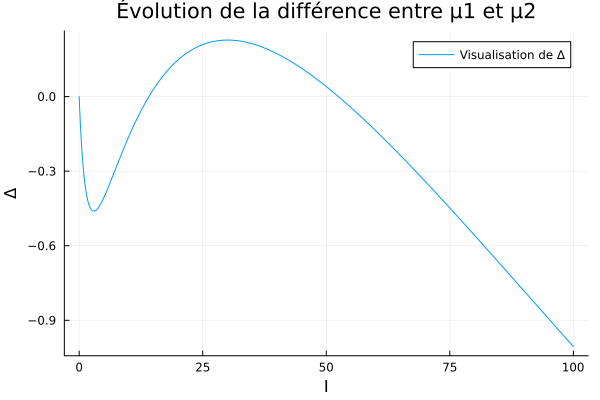

In [2]:
ΔI = 0.001
I_values = 0:ΔI:I_max

μ1_values = μN_1.(I_values) 
μ2_values = μN_2.(I_values)

Δ = μ1_values - μ2_values

I_barre = I_values[argmax(Δ)]
I_min = I_values[argmin(Δ[1:argmax(Δ)])]


print(I_min,'\n')
print(I_barre)

Δ_plot = plot(I_values, Δ, xlabel = "I", ylabel = "Δ", label = "Visualisation de Δ", title = "Évolution de la différence entre μ1 et μ2")

display(Δ_plot)

In [3]:
using JuMP, Ipopt, Plots, MINPACK

# JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 10))
set_optimizer_attribute(sys, "tol", 1e-3)
set_optimizer_attribute(sys, "constr_viol_tol", 1e-3)
set_optimizer_attribute(sys, "max_iter", 1000)
set_optimizer_attribute(sys, "check_derivatives_for_naninf", "yes")

# Variables (some state constraints have been added to ease convergence)

@variables(sys, begin
    Δt == Tmax / N
    
    0.0 ≤ x1[1:N+1]
    0.0 ≤ x2[1:N+1]

    I_min ≤ I[1:N+1] ≤ Imax # 0 I_min
end)

# Objective
ϵ = 0.0001
@NLobjective(sys, Max, (x1[N+1]+ϵ)/(x2[N+1]+ϵ))


# Boundary constraints
@constraints(sys, begin

    con_x1_init, x1[1] == 0.4
    con_x2_init, x2[1] == 0.3

end)


# Functions
function θ_1(I)
    return θ0_1 * K_1 / ( K_1 + I )
end
function θ_2(I)
    return θ0_2 * K_2 / ( K_2 + I )
end

function μg_1(I)
    return μ_m1 * I * θ_1(I) / ( I * θ_1(I) + Ks_1 )
end
function μg_2(I)
    return μ_m2 * I * θ_2(I) / ( I * θ_2(I) + Ks_2 )
end

function μN_1(I)
    return μg_1(I) - α_1 * I * θ_1(I)
end
function μN_2(I)
    return μg_2(I) - α_2 * I * θ_2(I)
end

# Register the functions for automatic differentiation
register(sys, :θ_1, 1, θ_1; autodiff = true)
register(sys, :θ_2, 1, θ_2; autodiff = true)
register(sys, :μg_1, 1, μg_1; autodiff = true)
register(sys, :μg_2, 1, μg_2; autodiff = true)
register(sys, :μN_1, 1, μN_1; autodiff = true)
register(sys, :μN_2, 1, μN_2; autodiff = true)


# Dynamics (nonlinear expressions)
@NLexpressions(sys, begin
    # x1
    dx1[i = 1:N+1], (μN_1(I[i]) - D) * x1[i]
    # x2
    dx2[i = 1:N+1], (μN_2(I[i]) - D) * x2[i]
end)

# Ajouter une contrainte explicite sur D pour éviter les valeurs négatives
@constraints(sys, begin
    con_I_pos[i = 1:N+1], Imax >= I[i] >= I_min # I_min # 0
end)


# Crank-Nicolson scheme (nonlinear constraints)
@NLconstraints(sys, begin
    con_dx1[i = 1:N], x1[i+1] == x1[i] + Δt * (dx1[i] + dx1[i+1]) / 2.0
    con_dx2[i = 1:N], x2[i+1] == x2[i] + Δt * (dx2[i] + dx2[i+1]) / 2.0
end)

# Solve the optimization problem
println("Solving...")
status = optimize!(sys)

# Check the results
if termination_status(sys) == MOI.OPTIMAL
    println("Solution is optimal")
elseif termination_status(sys) == MOI.LOCALLY_SOLVED
    println("Local solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("The model was not solved correctly.")
end
println("Objective value = ", objective_value(sys), "\n")

# Retrieve values (including duals)
Δtt = value.(Δt)
t = (1:N+1) * Δtt
t = (t[1:end-1] + t[2:end]) / 2.0  # Calcul des temps moyens

p = -[ [ dual(con_dx1[i]), dual(con_dx2[i])] for i in 1:N ]

Solving...

List of options:

                                    Name   Value                # times used
            check_derivatives_for_naninf = yes                       1
                         constr_viol_tol = 0.001                     5
                                max_iter = 1000                      1
                      obj_scaling_factor = -1                        1
                             print_level = 10                        2
                                     tol = 0.001                     2

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number o

2500-element Vector{Vector{Float64}}:
 [97651.59438834364, -113416.3317118205]
 [97483.22321704116, -113693.94647126974]
 [97315.14235342713, -113972.24076425159]
 [97147.35129694668, -114251.21625410454]
 [96979.84954790799, -114530.87460823856]
 [96812.63660748079, -114811.21749814501]
 [96645.71197769497, -115092.24659940678]
 [96479.07516143894, -115373.96359170807]
 [96312.72566245838, -115656.3701588447]
 [96146.6629853545, -115939.46798873399]
 ⋮
 [1326.7883684867381, -5.006205868849506e7]
 [1324.5007712724685, -5.0184600472386196e7]
 [1322.2171182668565, -5.030744221471438e7]
 [1319.937402669374, -5.043058464972181e7]
 [1317.6616176912185, -5.055402851344798e7]
 [1315.3897565552916, -5.067777454373408e7]
 [1313.1218124961806, -5.080182348022739e7]
 [1310.857778760138, -5.0926176064385734e7]
 [1308.5976486050604, -5.1050833039481886e7]

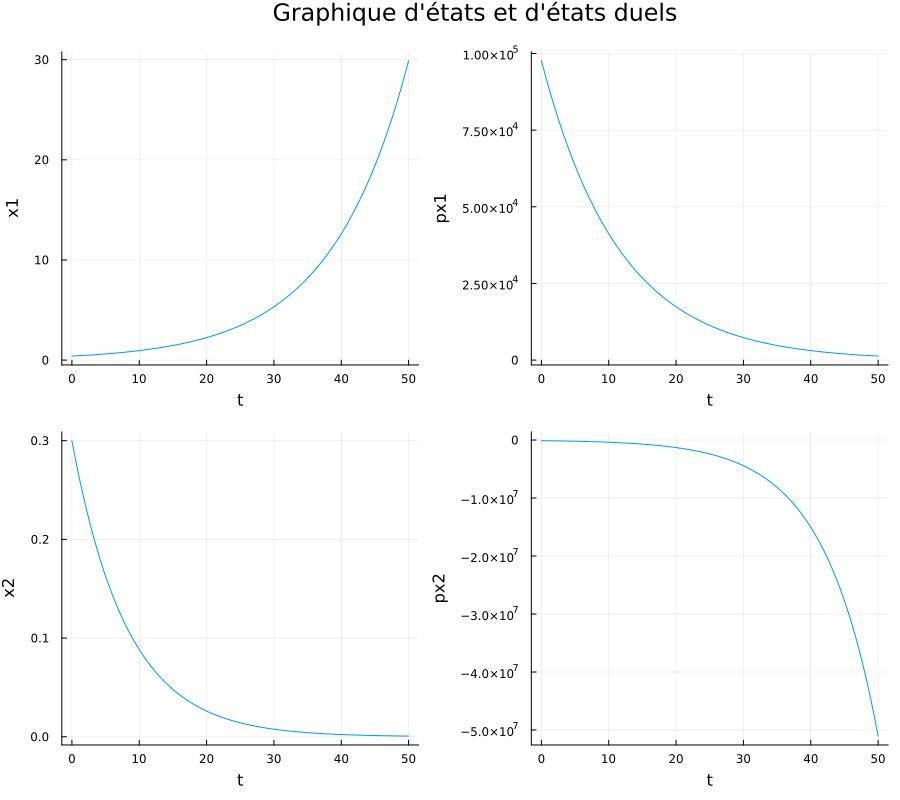

In [4]:
t = LinRange(0, Tmax, N+1)
tp = LinRange(0, Tmax, N)

x1_values = value.(x1)
x2_values = value.(x2)

x1_plot = plot(t, x1_values[1:N+1], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, x2_values[1:N+1], xlabel = "t", ylabel = "x2", legend = false)

x1_dual_plot = plot(tp, [ p[i][1] for i in 1:N ], xlabel = "t", ylabel = "px1", legend = false)
x2_dual_plot = plot(tp, [ p[i][2] for i in 1:N ], xlabel = "t", ylabel = "px2", legend = false)

state_plot = plot(x1_plot, x1_dual_plot, x2_plot, x2_dual_plot, size = (900, 800), layout = (2,2), plot_title="Graphique d'états et d'états duels")
display(state_plot)

μ1_values = μN_1.(I_values) 
μ2_values = μN_2.(I_values)

μ1_plot_bis = plot(t, μ1_values, xlabel = "t", ylabel = "μ1", legend = false)
μ2_plot_bis = plot(t, μ2_values, xlabel = "t", ylabel = "μ2", legend = false)

plot_bis = plot(μ1_plot_bis, μ2_plot_bis, size = (900, 500), layout = (1,2), plot_title="Graphique de croissance")
display(plot_bis)

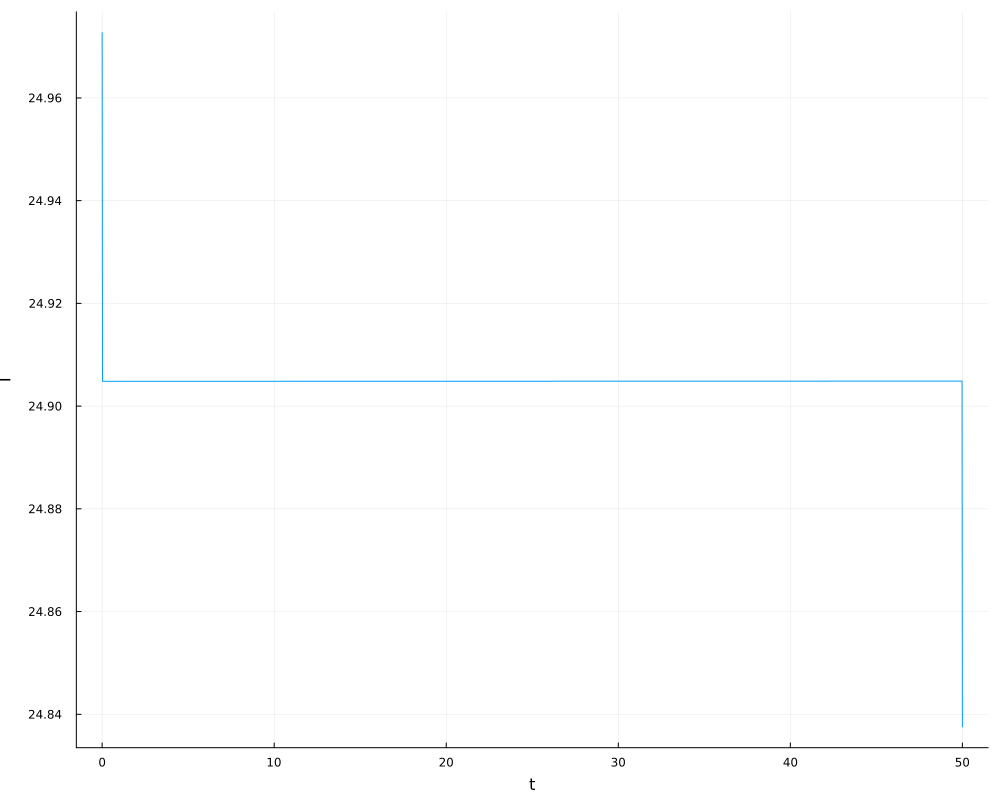

In [5]:
I_values = value.(I)
t = LinRange(0, Tmax, N+1)

I_plot = plot(t, I_values[1:N+1], xlabel = "t", ylabel = "I", legend = false)
control_plot1 = plot(I_plot, size = (1000, 800), layout = (1,1))
display(control_plot1)